In [1]:
img_dir = "Aerial_Landscapes"

# SIFT

In [2]:
import os
import cv2
import numpy as np

def load_sift_features(image_dir, max_per_class=30):
    sift = cv2.SIFT_create()
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            keypoints, descriptor = sift.detectAndCompute(img, None)
            if descriptor is not None:
                descriptor = descriptor.mean(axis=0)
                features.append(descriptor)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features, labels = load_sift_features(img_dir, max_per_class=800)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

classifiers = {
    "SVM (Linear)": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(),
    "kNN": KNeighborsClassifier()
}

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))


--- SVM (Linear) ---
              precision    recall  f1-score   support

 Agriculture     0.6120    0.7000    0.6531       160
     Airport     0.5079    0.6062    0.5527       160
       Beach     0.6296    0.6375    0.6335       160
        City     0.6810    0.6937    0.6873       160
      Desert     0.6689    0.6556    0.6622       151
      Forest     0.8303    0.8562    0.8431       160
   Grassland     0.5592    0.5484    0.5537       155
     Highway     0.5706    0.5813    0.5759       160
        Lake     0.3663    0.3962    0.3807       159
    Mountain     0.8146    0.7688    0.7910       160
     Parking     0.9020    0.8625    0.8818       160
        Port     0.8417    0.7312    0.7826       160
     Railway     0.6755    0.6375    0.6559       160
 Residential     0.8043    0.6937    0.7450       160
       River     0.3831    0.3688    0.3758       160

    accuracy                         0.6495      2385
   macro avg     0.6565    0.6492    0.6516      2385
weig

## visualisation of sift feature extraction

In [4]:
import cv2
import os
import matplotlib.pyplot as plt

def visualize_sift_and_save(image_dir, target_classes=['Lake', 'River'], num_images_per_class=2, save_dir='res'):
    sift = cv2.SIFT_create()
    
    os.makedirs(save_dir, exist_ok=True)

    for class_name in target_classes:
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            print(f"[WARNING] Class directory not found: {class_path}")
            continue
        
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files = files[:num_images_per_class]
        
        for i, file in enumerate(files):
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            keypoints, descriptors = sift.detectAndCompute(gray, None)
            
            img_with_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(img_with_kp, cv2.IMREAD_GRAYSCALE))
            plt.title(f"{class_name} - Sample {i+1}\nKeypoints: {len(keypoints)}")
            plt.axis('off')
            
            save_path = os.path.join(save_dir, f"sift_{class_name.lower()}_{i+1}.png")
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()

            print(f"[SAVED] {save_path} | Descriptors: {None if descriptors is None else descriptors.shape}")

In [5]:
visualize_sift_and_save(img_dir, target_classes=['Lake', 'River', 'Beach', 'Grassland', 'Agriculture'], num_images_per_class=5)

[SAVED] res/sift_lake_1.png | Descriptors: (748, 128)
[SAVED] res/sift_lake_2.png | Descriptors: (435, 128)
[SAVED] res/sift_lake_3.png | Descriptors: (482, 128)
[SAVED] res/sift_lake_4.png | Descriptors: (255, 128)
[SAVED] res/sift_lake_5.png | Descriptors: (603, 128)
[SAVED] res/sift_river_1.png | Descriptors: (324, 128)
[SAVED] res/sift_river_2.png | Descriptors: (466, 128)
[SAVED] res/sift_river_3.png | Descriptors: (521, 128)
[SAVED] res/sift_river_4.png | Descriptors: (556, 128)
[SAVED] res/sift_river_5.png | Descriptors: (477, 128)
[SAVED] res/sift_beach_1.png | Descriptors: (125, 128)
[SAVED] res/sift_beach_2.png | Descriptors: (489, 128)
[SAVED] res/sift_beach_3.png | Descriptors: (404, 128)
[SAVED] res/sift_beach_4.png | Descriptors: (368, 128)
[SAVED] res/sift_beach_5.png | Descriptors: (216, 128)
[SAVED] res/sift_grassland_1.png | Descriptors: (2, 128)
[SAVED] res/sift_grassland_2.png | Descriptors: (151, 128)
[SAVED] res/sift_grassland_3.png | Descriptors: (87, 128)
[SAVED

# LBP

In [6]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def extract_lbp_features(image_path, radius):
    n_points = 8 * radius
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    '''img = cv2.resize(img, (128, 128))'''
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, n_points + 3),
                             range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def load_lbp_features(image_dir, radius=1, max_per_class=30):
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            feat = extract_lbp_features(img_path, radius)
            if feat is not None:
                features.append(feat)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

classifiers = {
    "SVM (RBF)": SVC(kernel='rbf'),
    "Random Forest": RandomForestClassifier(),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

features, labels = load_lbp_features(img_dir, max_per_class=800)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42)

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))


--- SVM (RBF) ---
              precision    recall  f1-score   support

 Agriculture     0.4780    0.5437    0.5088       160
     Airport     0.3424    0.3937    0.3663       160
       Beach     0.4906    0.3250    0.3910       160
        City     0.3566    0.3187    0.3366       160
      Desert     0.4833    0.5437    0.5118       160
      Forest     0.7077    0.8625    0.7775       160
   Grassland     0.7203    0.6438    0.6799       160
     Highway     0.5089    0.3563    0.4191       160
        Lake     0.6476    0.4250    0.5132       160
    Mountain     0.4498    0.7000    0.5477       160
     Parking     0.4875    0.4875    0.4875       160
        Port     0.6887    0.6500    0.6688       160
     Railway     0.5500    0.4813    0.5133       160
 Residential     0.4354    0.5687    0.4932       160
       River     0.3191    0.2812    0.2990       160

    accuracy                         0.5054      2400
   macro avg     0.5111    0.5054    0.5009      2400
weighte

## Plot confusion matrix

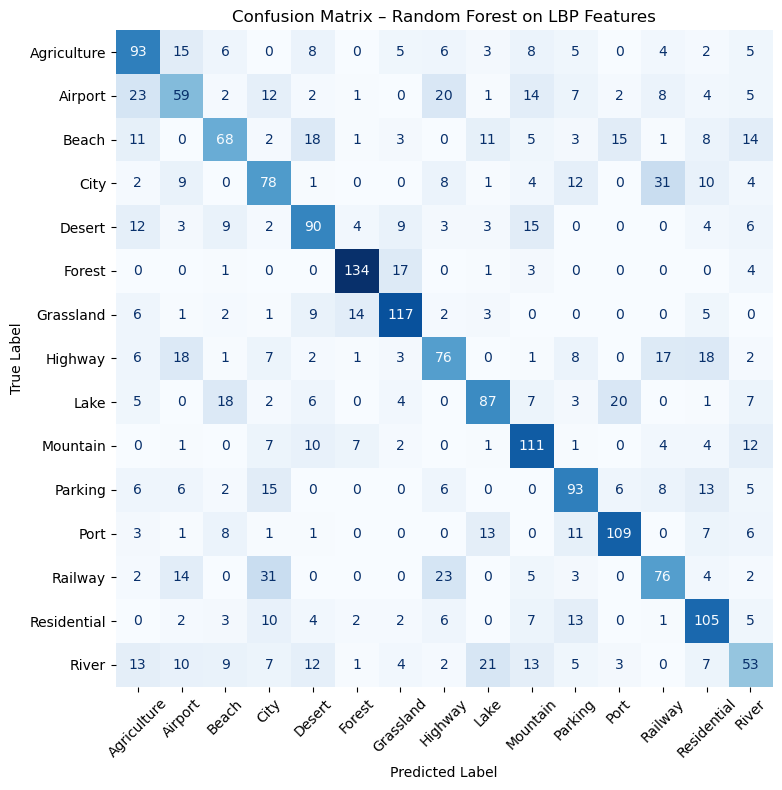

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

features, labels = load_lbp_features(img_dir, max_per_class=800)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title("Confusion Matrix – Random Forest on LBP Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Plot LBP histogram

### plot mean and std of histogram for each class

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

def plot_lbp_mean_std(img_dir, class_name, num_images=800, radius=1, method='uniform'):
    n_points = 8 * radius
    class_path = os.path.join(img_dir, class_name)
    image_files = sorted([f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')])[:num_images]

    hists = []
    for f in image_files:
        img_path = os.path.join(class_path, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        lbp = local_binary_pattern(img, n_points, radius, method=method)
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        hists.append(hist)

    hists = np.array(hists)
    mean_hist = np.mean(hists, axis=0)
    std_hist = np.std(hists, axis=0)
    x = range(len(mean_hist))

    plt.figure(figsize=(8, 6))
    plt.plot(x, mean_hist, label='Mean', color='blue')
    plt.fill_between(x, mean_hist - std_hist, mean_hist + std_hist, alpha=0.2, color='blue', label='±1 Std Dev')
    plt.title(f'LBP Histogram Variation – {class_name}')
    plt.xlabel('LBP Pattern Bin')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join('res', f'lbp_mean_std_{class_name}.png'))
    plt.close()

In [10]:
import os

for class_name in os.listdir(img_dir):
    class_path = os.path.join(img_dir, class_name)
    if os.path.isdir(class_path):
        plot_lbp_mean_std(img_dir, class_name)


### calculate and plot pairwise distance(difference) of histograms

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage.feature import local_binary_pattern
from scipy.spatial.distance import cdist

def plot_lbp_distance_boxplot(img_dir, num_images=800, radius=1, method='uniform'):
    n_points = 8 * radius
    class_dirs = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])
    class_means = []

    for class_name in class_dirs:
        class_path = os.path.join(img_dir, class_name)
        image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))])[:num_images]

        hists = []
        for f in image_files:
            img_path = os.path.join(class_path, f)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            lbp = local_binary_pattern(img, n_points, radius, method=method)
            n_bins = int(lbp.max() + 1)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            hists.append(hist)

        if hists:
            class_means.append(np.mean(hists, axis=0))

    # Compute pairwise distance matrix
    dist_matrix = cdist(class_means, class_means, metric='euclidean')

    # Flatten for boxplot-style DataFrame
    boxplot_data = []
    for i, class_name in enumerate(class_dirs):
        distances = np.delete(dist_matrix[i], i)  # exclude diagonal
        for val in distances:
            boxplot_data.append({'Class': class_name, 'Distance': val})

    df = pd.DataFrame(boxplot_data)

    class_order_median = df.groupby('Class')['Distance'].median().sort_values().index.tolist()

    plt.figure(figsize=(10, 8))
    sns.boxplot(x='Class', y='Distance', data=df, order=class_order_median, palette='coolwarm', showfliers=False)

    plt.title("Class-wise Distribution of Mean LBP Histogram Distances", fontsize=12)
    plt.ylabel("Pairwise Euclidean Distance")
    plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join('res', f'lbp_distance_boxplot.png'))
    plt.close()

In [12]:
plot_lbp_distance_boxplot(img_dir)

/var/folders/1k/n2dv6h7n62jdql9drr8dh3zm0000gn/T/ipykernel_72258/1031831960.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Distance', data=df, order=class_order_median, palette='coolwarm', showfliers=False)


# Image Preprocessing

In [13]:
def preprocess_image(img):
    '''img = cv2.resize(img, (128, 128))'''
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    return img

## SIFT

In [14]:
def load_sift_features_preprocess(image_dir, max_per_class=30):
    sift = cv2.SIFT_create()
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = preprocess_image(img)

            keypoints, descriptor = sift.detectAndCompute(img, None)
            if descriptor is not None:
                descriptor = descriptor.mean(axis=0)
                features.append(descriptor)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features, labels = load_sift_features_preprocess(img_dir, max_per_class=800)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

classifiers = {
    "SVM (Linear)": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(),
    "kNN": KNeighborsClassifier()
}

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))


--- SVM (Linear) ---
              precision    recall  f1-score   support

 Agriculture     0.7063    0.7063    0.7063       160
     Airport     0.5479    0.6438    0.5920       160
       Beach     0.6949    0.7688    0.7300       160
        City     0.7714    0.6750    0.7200       160
      Desert     0.6312    0.6312    0.6312       160
      Forest     0.8293    0.8500    0.8395       160
   Grassland     0.6957    0.7000    0.6978       160
     Highway     0.6726    0.7063    0.6890       160
        Lake     0.4337    0.4500    0.4417       160
    Mountain     0.7746    0.8375    0.8048       160
     Parking     0.8497    0.8125    0.8307       160
        Port     0.7919    0.7375    0.7638       160
     Railway     0.7103    0.6438    0.6754       160
 Residential     0.8182    0.8438    0.8308       160
       River     0.4198    0.3438    0.3780       160

    accuracy                         0.6900      2400
   macro avg     0.6898    0.6900    0.6887      2400
weig

## LBP

In [16]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
def preprocess_image(img):
    '''img = cv2.resize(img, (128, 128))'''
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    return img

radius = 1
n_points = 8 * radius

def extract_lbp_feature_preprocess(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = preprocess_image(img)
    '''img = cv2.resize(img, (128, 128))'''
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, n_points + 3),
                             range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def load_lbp_features_preprocess(image_dir, max_per_class=30):
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            feat = extract_lbp_feature_preprocess(img_path)
            if feat is not None:
                features.append(feat)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

classifiers = {
    "SVM (RBF)": SVC(kernel='rbf'),
    "Random Forest": RandomForestClassifier(),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

features, labels = load_lbp_features_preprocess(img_dir, max_per_class=800)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42)

for name, clf in classifiers.items():
    print(f"\n--- {name} lbp after preprocessing ---")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))


--- SVM (RBF) lbp after preprocessing ---
              precision    recall  f1-score   support

 Agriculture     0.4190    0.4688    0.4425       160
     Airport     0.2889    0.2437    0.2644       160
       Beach     0.4815    0.3250    0.3881       160
        City     0.4269    0.4562    0.4411       160
      Desert     0.4798    0.5188    0.4985       160
      Forest     0.6802    0.8375    0.7507       160
   Grassland     0.6627    0.6875    0.6748       160
     Highway     0.4322    0.3187    0.3669       160
        Lake     0.6050    0.4500    0.5161       160
    Mountain     0.4722    0.7438    0.5777       160
     Parking     0.6303    0.6500    0.6400       160
        Port     0.7174    0.6188    0.6644       160
     Railway     0.4929    0.4313    0.4600       160
 Residential     0.3789    0.4500    0.4114       160
       River     0.2617    0.2437    0.2524       160

    accuracy                         0.4963      2400
   macro avg     0.4953    0.4963    

# Computational Trade-off

### SIFT 640/160

In [18]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features, labels = load_sift_features_preprocess(img_dir, max_per_class=800)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

clf = SVC(kernel='linear')

start_time = time.time()
clf.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

Training time: 40.66 seconds
              precision    recall  f1-score   support

 Agriculture     0.7063    0.7063    0.7063       160
     Airport     0.5479    0.6438    0.5920       160
       Beach     0.6949    0.7688    0.7300       160
        City     0.7714    0.6750    0.7200       160
      Desert     0.6312    0.6312    0.6312       160
      Forest     0.8293    0.8500    0.8395       160
   Grassland     0.6957    0.7000    0.6978       160
     Highway     0.6726    0.7063    0.6890       160
        Lake     0.4337    0.4500    0.4417       160
    Mountain     0.7746    0.8375    0.8048       160
     Parking     0.8497    0.8125    0.8307       160
        Port     0.7919    0.7375    0.7638       160
     Railway     0.7103    0.6438    0.6754       160
 Residential     0.8182    0.8438    0.8308       160
       River     0.4198    0.3438    0.3780       160

    accuracy                         0.6900      2400
   macro avg     0.6898    0.6900    0.6887      24

### SIFT 160/160

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time

features, labels = load_sift_features_preprocess(img_dir, max_per_class=320)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.5, stratify=labels, random_state=42
)

clf = SVC(kernel='linear')

start_time = time.time()
clf.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

Training time: 0.80 seconds
              precision    recall  f1-score   support

 Agriculture     0.6135    0.6250    0.6192       160
     Airport     0.3959    0.4875    0.4370       160
       Beach     0.5879    0.6062    0.5969       160
        City     0.6111    0.6875    0.6471       160
      Desert     0.5312    0.5312    0.5312       160
      Forest     0.7222    0.8125    0.7647       160
   Grassland     0.6620    0.5875    0.6225       160
     Highway     0.5671    0.5813    0.5741       160
        Lake     0.3214    0.3937    0.3539       160
    Mountain     0.7262    0.7625    0.7439       160
     Parking     0.8816    0.8375    0.8590       160
        Port     0.7800    0.7312    0.7548       160
     Railway     0.6777    0.5125    0.5836       160
 Residential     0.8194    0.7937    0.8063       160
       River     0.3364    0.2250    0.2697       160

    accuracy                         0.6117      2400
   macro avg     0.6156    0.6117    0.6109      240

### LBP 640/160

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

features, labels = load_lbp_features_preprocess(img_dir, max_per_class=800)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42)

clf = RandomForestClassifier()

start_time = time.time()
clf.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))


Training time: 2.35 seconds
              precision    recall  f1-score   support

 Agriculture     0.5367    0.5938    0.5638       160
     Airport     0.3875    0.3875    0.3875       160
       Beach     0.5556    0.5000    0.5263       160
        City     0.5082    0.5813    0.5423       160
      Desert     0.5229    0.5000    0.5112       160
      Forest     0.8144    0.8500    0.8318       160
   Grassland     0.7205    0.7250    0.7227       160
     Highway     0.5490    0.5250    0.5367       160
        Lake     0.6047    0.4875    0.5398       160
    Mountain     0.6056    0.6813    0.6412       160
     Parking     0.7081    0.7125    0.7103       160
        Port     0.6928    0.6625    0.6773       160
     Railway     0.5442    0.5000    0.5212       160
 Residential     0.5243    0.6062    0.5623       160
       River     0.4286    0.3937    0.4104       160

    accuracy                         0.5804      2400
   macro avg     0.5802    0.5804    0.5790      240

# Fusion - add discussion on time if we have space and time

In [21]:
import cv2
import numpy as np
import os

def load_sift_edge_features(image_dir, max_per_class=30):
    sift = cv2.SIFT_create()
    features, labels = [], []

    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break

            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # sift
            keypoints, descriptor = sift.detectAndCompute(img, None)
            if descriptor is None:
                continue
            sift_descriptor = descriptor.mean(axis=0)

            # edge - canny
            edges = cv2.Canny(img, 100, 200)
            edge_hist = np.histogram(edges, bins=2, range=(0, 256))[0]
            edge_mean = np.mean(edges)

            # combine
            combined = np.concatenate((sift_descriptor, edge_hist, [edge_mean]))

            features.append(combined)
            labels.append(class_name)
            count += 1

    return np.array(features), np.array(labels)

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features, labels = load_sift_edge_features(img_dir, max_per_class=800)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

clf = SVC(kernel='linear')

print("sift + edge features")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

sift + edge features
              precision    recall  f1-score   support

 Agriculture     0.6395    0.6875    0.6627       160
     Airport     0.5750    0.5750    0.5750       160
       Beach     0.6770    0.6813    0.6791       160
        City     0.6906    0.7812    0.7331       160
      Desert     0.6643    0.6291    0.6463       151
      Forest     0.7627    0.8438    0.8012       160
   Grassland     0.5939    0.6323    0.6125       155
     Highway     0.6358    0.6438    0.6398       160
        Lake     0.4000    0.3396    0.3673       159
    Mountain     0.7874    0.8562    0.8204       160
     Parking     0.9231    0.9000    0.9114       160
        Port     0.7877    0.7188    0.7516       160
     Railway     0.6774    0.6562    0.6667       160
 Residential     0.8205    0.8000    0.8101       160
       River     0.4577    0.4062    0.4305       160

    accuracy                         0.6771      2385
   macro avg     0.6728    0.6767    0.6738      2385
weigh